# **Proyecto de Minería de Datos: Análisis y Pronóstico de Demanda de Energía Eléctrica**

### **Autor:**  
**Deyvis Quispe Mamani**

### **Curso:**  
**Minería de Datos**

### **Docente:**  
**Abel Ángel Sullón Macalupu**

---

### **Descripción del Proyecto**

Este proyecto aplica técnicas de **análisis de series de tiempo** para estudiar el comportamiento de la **demanda diaria de energía eléctrica** y generar pronósticos a corto plazo.  
El conjunto de datos simula mediciones reales de consumo energético, temperatura ambiental, días feriados y precipitaciones, con el objetivo de explorar la influencia de factores externos en la variación del consumo.

El flujo de trabajo incluye:

1. **Carga y exploración de la serie temporal.**  
2. **Visualización del comportamiento histórico** y detección de patrones estacionales.  
3. **División temporal** en conjuntos de entrenamiento y prueba.  
4. **Modelos base**: *Naive* y *Seasonal-Naive (7 días)* para establecer referencias.  
5. **Modelo principal:** *SARIMAX* con regresores exógenos (*temperatura, lluvia y feriados*).  
6. **Evaluación del desempeño** mediante métricas **MAE**, **RMSE** y **MAPE**.  
7. **Visualización de resultados**: comparación de valores reales vs. predichos y análisis de residuales.  
8. **Pronóstico a futuro (30 días)** utilizando los patrones históricos y las variables exógenas promedio.  
9. **Exportación del modelo entrenado** (`sarimax_demanda.joblib`) y definición de funciones para generar pronósticos automáticos.

---

### **Estructura del Notebook**

El archivo mantiene el formato estructurado de los laboratorios previos, dividido en secciones numeradas para facilitar la comprensión y ejecución paso a paso del flujo analítico.

---

### **Palabras clave**
`Minería de Datos`, `Series de Tiempo`, `SARIMAX`, `Pronóstico`, `Python`, `Scikit-learn`, `Statsmodels`

---


In [1]:
# =========================================
# 1) Cargar datos y preparar serie temporal
# =========================================
import os, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

DATA_FILE = "/content/demanda_energia_diaria.csv"
TARGET = "Demanda_MWh"
DATE_COL = "Fecha"

assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"

df = pd.read_csv(DATA_FILE, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL)
df.set_index(DATE_COL, inplace=True)

print("Rango de fechas:", df.index.min(), "->", df.index.max())
print("Dimensiones:", df.shape)
display(df.head())

y = df[TARGET]
X = df.drop(columns=[TARGET])
y.describe()


Rango de fechas: 2022-01-01 00:00:00 -> 2024-12-31 00:00:00
Dimensiones: (1096, 5)


,Demanda_MWh,Temp_C,EsFeriado,Precio_kWh,Lluvia_mm
Fecha,,,,,
2022-01-01,1586.7,16.1,1,0.179,0.8
2022-01-02,1721.3,19.6,0,0.178,2.1
2022-01-03,1957.5,19.4,0,0.180,1.1
2022-01-04,1734.9,15.1,0,0.182,1.3
2022-01-05,1762.3,15.8,0,0.181,0.0


,Demanda_MWh
count,1096.000000
mean,1749.537682
std,320.664884
min,500.000000
25%,1577.425000
50%,1785.300000
75%,1979.200000
max,2418.500000


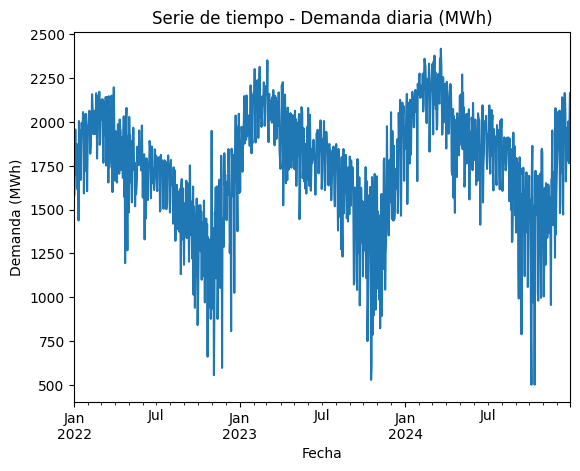

In [2]:
# =========================================
# 2) Visualización inicial
# =========================================
import matplotlib.pyplot as plt

plt.figure()
y.plot()
plt.title("Serie de tiempo - Demanda diaria (MWh)")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MWh)")
plt.show()


In [3]:
# =========================================
# 3) División Train / Test por tiempo
# =========================================
import pandas as pd

test_days = 90
split_point = y.index.max() - pd.Timedelta(days=test_days-1)

y_train = y.loc[:split_point - pd.Timedelta(days=1)]
y_test  = y.loc[split_point:]
X_train = X.loc[y_train.index]
X_test  = X.loc[y_test.index]

print("Train:", y_train.index.min(), "->", y_train.index.max(), len(y_train))
print("Test :", y_test.index.min(),  "->", y_test.index.max(), len(y_test))


Train: 2022-01-01 00:00:00 -> 2024-10-02 00:00:00 1006
Test : 2024-10-03 00:00:00 -> 2024-12-31 00:00:00 90


In [4]:
# =========================================
# 4) Modelos base (Naive y S-Naive)
# =========================================
import numpy as np
import pandas as pd

naive_pred = pd.Series(y_train.iloc[-1], index=y_test.index)

seasonal_period = 7
s_naive_pred = y.shift(seasonal_period).loc[y_test.index]
s_naive_pred = s_naive_pred.fillna(method="bfill")

def metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

base_naive = metrics(y_test, naive_pred)
base_snaive = metrics(y_test, s_naive_pred)
base_naive, base_snaive


({'MAE': np.float64(320.5877777777778),
  'RMSE': np.float64(391.53819666086787),
  'MAPE': np.float64(22.851743323832977)},
 {'MAE': np.float64(269.58666666666664),
  'RMSE': np.float64(340.03903664791846),
  'MAPE': np.float64(19.060779268638306)})

In [5]:
# =========================================
# 5) SARIMAX con regresores exógenos
# =========================================
import statsmodels.api as sm

exog_cols = ["Temp_C", "EsFeriado", "Lluvia_mm"]
exog_train = X_train[exog_cols]
exog_test  = X_test[exog_cols]

order = (2,0,2)
seasonal_order = (1,1,1,7)

sarimax = sm.tsa.statespace.SARIMAX(
    endog=y_train,
    exog=exog_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarimax.summary().tables[0])


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         Demanda_MWh   No. Observations:                 1006
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -6530.803
Date:                             Mon, 03 Nov 2025   AIC                          13081.606
Time:                                     23:57:34   BIC                          13130.573
Sample:                                 01-01-2022   HQIC                         13100.227
                                      - 10-02-2024                                         
Covariance Type:                               opg                                         


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
# =========================================
# 6) Pronóstico en test y evaluación
# =========================================
pred = sarimax.get_prediction(start=y_test.index[0], end=y_test.index[-1], exog=X_test[["Temp_C","EsFeriado","Lluvia_mm"]])
y_pred = pred.predicted_mean

import numpy as np
import pandas as pd

def metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

res_base = pd.DataFrame([
    {"model": "Naive", **metrics(y_test, pd.Series(y_train.iloc[-1], index=y_test.index))},
    {"model": "S-Naive(7)", **metrics(y_test, y.shift(7).loc[y_test.index].fillna(method='bfill'))},
    {"model": "SARIMAX", **metrics(y_test, y_pred)}
]).sort_values("RMSE")

res_base


,model,MAE,RMSE,MAPE
2,SARIMAX,204.897635,254.726430,15.512713
1,S-Naive(7),269.586667,340.039037,19.060779
0,Naive,320.587778,391.538197,22.851743


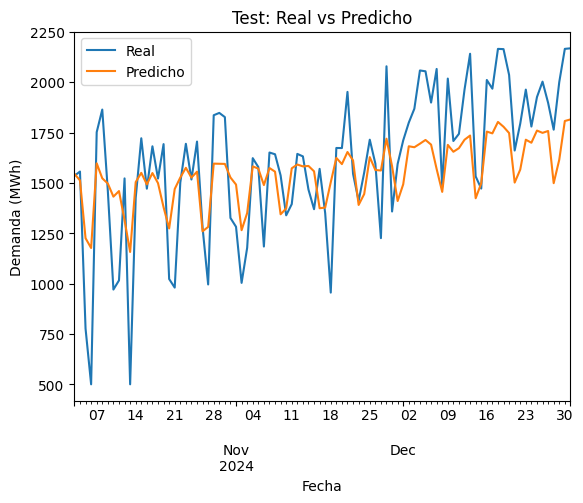

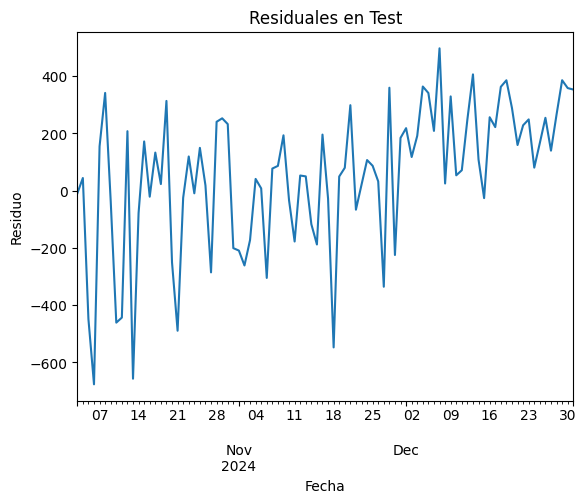

In [7]:
# =========================================
# 7) Gráficos: real vs predicho y residuales
# =========================================
import matplotlib.pyplot as plt

plt.figure()
y_test.plot(label="Real")
y_pred.plot(label="Predicho")
plt.title("Test: Real vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MWh)")
plt.legend()
plt.show()

plt.figure()
resid = y_test - y_pred
resid.plot()
plt.title("Residuales en Test")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.show()


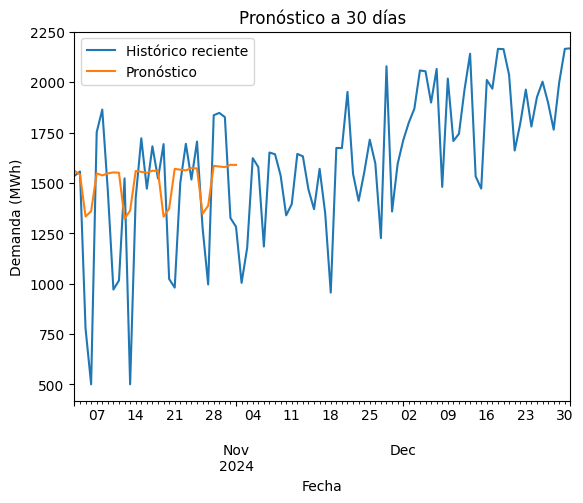

In [8]:
# =========================================
# 8) Pronóstico a futuro (30 días)
# =========================================
h = 30
last_date = y.index.max()
future_idx = pd.date_range(last_date + pd.Timedelta(days=1), periods=h, freq="D")

tmp_tail = X[["Temp_C","EsFeriado","Lluvia_mm"]].tail(30)
future_exog = pd.DataFrame({
    "Temp_C": [tmp_tail["Temp_C"].mean()]*h,
    "EsFeriado": [0]*h,
    "Lluvia_mm": [tmp_tail["Lluvia_mm"].mean()]*h
}, index=future_idx)

forecast_res = sarimax.get_forecast(steps=h, exog=future_exog)
y_fc = forecast_res.predicted_mean

import matplotlib.pyplot as plt
plt.figure()
y.tail(90).plot(label="Histórico reciente")
y_fc.plot(label="Pronóstico")
plt.title("Pronóstico a 30 días")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MWh)")
plt.legend()
plt.show()


In [9]:
# =========================================
# 9) Guardado de modelo
# =========================================
import joblib, os
ARTIFACT_MODEL = "sarimax_demanda.joblib"
joblib.dump(sarimax, ARTIFACT_MODEL)
os.path.exists(ARTIFACT_MODEL)


True

In [11]:
# =========================================
# 10) Funciones de inferencia (fix)
# =========================================
import os
import pandas as pd
import joblib

EXOG_COLS = ["Temp_C", "EsFeriado", "Lluvia_mm"]  # mismo orden que en el entrenamiento
DATA_FILE = "demanda_energia_diaria.csv"

def forecast_h(steps=14, temp_c=22.0, es_feriado=0, lluvia_mm=0.0):
    mdl = joblib.load("sarimax_demanda.joblib")

    # Obtener la última fecha del dataset (índice temporal original)
    df_last = pd.read_csv(DATA_FILE, parse_dates=["Fecha"])[["Fecha"]]
    last_date = df_last["Fecha"].max()

    # Construir índice futuro y exógenas futuras en el mismo orden
    idx = pd.date_range(last_date + pd.Timedelta(days=1), periods=steps, freq="D")
    exog = pd.DataFrame({
        "Temp_C": [temp_c]*steps,
        "EsFeriado": [es_feriado]*steps,
        "Lluvia_mm": [lluvia_mm]*steps
    }, index=idx)[EXOG_COLS]

    fc = mdl.get_forecast(steps=steps, exog=exog).predicted_mean
    return fc

# Ejemplo
forecast_h(steps=7, temp_c=24, es_feriado=0, lluvia_mm=1.0).to_frame("Pronostico")



,Pronostico
2024-10-03,1703.312811
2024-10-04,1684.622811
2024-10-05,1476.348620
2024-10-06,1502.452678
2024-10-07,1690.597008
2024-10-08,1680.344501
2024-10-09,1690.344796
